# FEATURE ENGINEERING WITH PYSPARK
## important aspect of machine learning
### before diving to analysis
   - Become your own expert 
   - define your goals for analysis and how the output might be used
   - research data 
   - be curious
### data science project
#### Project Scoping / Data collection -> Exploratory ANalysis -> Data cleaning -> Feature Engineering -> model treining -> Project delivery / insights

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("feature_eng").config("spark.sql.legacy.timeParserPolicy", "LEGACY").getOrCreate()

In [3]:
import sys
print("spark version: ", spark.version)
print("python version: ", sys.version_info)

spark version:  3.5.4
python version:  sys.version_info(major=3, minor=10, micro=18, releaselevel='final', serial=0)


# advantage of parquet data format
   - ## Stored Column-wise
        - ### Fast to query column subsets
   - ## Structured, defined schema
        - ### Fields and data types defined
        - ### Great for messy text data
   - ## industry adopted

In [24]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dschettler8845/recsys-2020-ecommerce-dataset")

print("Path to dataset files:", path)

C:\Users\kizer\miniconda3\envs\spark354_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\kizer\.cache\kagglehub\datasets\dschettler8845\recsys-2020-ecommerce-dataset\versions\1


In [2]:
whole_path_test = "C:\\Users\\kizer\\.cache\\kagglehub\\datasets\\dschettler8845\\recsys-2020-ecommerce-dataset\\versions\\1\\test.parquet"
whole_path_train = "C:\\Users\\kizer\\.cache\\kagglehub\\datasets\\dschettler8845\\recsys-2020-ecommerce-dataset\\versions\\1\\train.parquet"

In [3]:
df = spark.read.parquet(whole_path_train)
df.show()

+--------------------+----------+----------+-------+-------+---------+--------------------+------+-----------+----------+---------+-----+-------------------+-------+---------+----------+------+--------+-------+
|          event_time|event_type|product_id|  brand|  price|  user_id|        user_session|target|      cat_0|     cat_1|    cat_2|cat_3|          timestamp|ts_hour|ts_minute|ts_weekday|ts_day|ts_month|ts_year|
+--------------------+----------+----------+-------+-------+---------+--------------------+------+-----------+----------+---------+-----+-------------------+-------+---------+----------+------+--------+-------+
|2019-11-01 00:00:...|      cart|   1005014|samsung| 503.09|533326659|6b928be2-2bce-464...|     0|electronics|smartphone|       NA|   NA|2019-11-01 01:00:14|      0|        0|         4|     1|      11|   2019|
|2019-11-01 00:03:...|      cart|   1005115|  apple| 949.47|565865924|fd4bd6d4-bd14-4fd...|     0|electronics|smartphone|       NA|   NA|2019-11-01 01:03:39

In [4]:
df.describe()

DataFrame[summary: string, event_time: string, event_type: string, product_id: string, brand: string, price: string, user_id: string, user_session: string, target: string, cat_0: string, cat_1: string, cat_2: string, cat_3: string, ts_hour: string, ts_minute: string, ts_weekday: string, ts_day: string, ts_month: string, ts_year: string]

In [4]:
from pyspark.sql.types import DateType, IntegerType, DoubleType
df_casted = df.withColumn("price_int", df["price"].cast(DoubleType())).withColumn("ts_month_int", df["ts_month"].cast(IntegerType())).withColumn("ts_year_int", df["ts_year"].cast(IntegerType())).withColumn("ts_day_int", df["ts_day"].cast(IntegerType())).withColumn("ts_weekday_int", df["ts_weekday"].cast(IntegerType()))
columns_to_drop = ['ts_month', 'price', 'ts_year', 'ts_day', 'ts_weekday']
df_casted = df_casted.drop(*columns_to_drop)
#df_casted = df_casted.withColumn("event_time_corr", to_timestamp(df["event_time"], "yyyy-MM-dd HH:mm:ss"))
df_casted.show()

+--------------------+----------+----------+-------+---------+--------------------+------+-----------+----------+---------+-----+-------------------+-------+---------+---------+------------+-----------+----------+--------------+
|          event_time|event_type|product_id|  brand|  user_id|        user_session|target|      cat_0|     cat_1|    cat_2|cat_3|          timestamp|ts_hour|ts_minute|price_int|ts_month_int|ts_year_int|ts_day_int|ts_weekday_int|
+--------------------+----------+----------+-------+---------+--------------------+------+-----------+----------+---------+-----+-------------------+-------+---------+---------+------------+-----------+----------+--------------+
|2019-11-01 00:00:...|      cart|   1005014|samsung|533326659|6b928be2-2bce-464...|     0|electronics|smartphone|       NA|   NA|2019-11-01 01:00:14|      0|        0|   503.09|          11|       2019|         1|             4|
|2019-11-01 00:03:...|      cart|   1005115|  apple|565865924|fd4bd6d4-bd14-4fd...| 

In [6]:
df_casted.describe(['price_int']).show()

+-------+-----------------+
|summary|        price_int|
+-------+-----------------+
|  count|         11495242|
|   mean|287.9644098358388|
| stddev|331.5377135506471|
|    min|              0.0|
|    max|          2574.07|
+-------+-----------------+



In [7]:
df_casted.agg({'price_int': 'mean'}).collect()

[Row(avg(price_int)=287.9644098358388)]

In [10]:
df_casted.cov('price_int', 'ts_month_int')

-14.229403072645727

In [11]:
df_casted.count()

11495242

In [12]:
df_casted.sample(False, 0.5, 42).count()

5747189

C:\Users\kizer\AppData\Local\Temp\ipykernel_54004\1783027884.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pandas_df)


<Axes: ylabel='Density'>

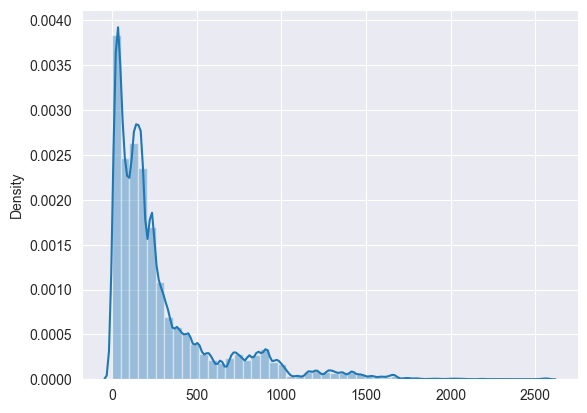

In [13]:
import seaborn as sns

sample_df = df_casted.select('price_int').sample(False, 0.5, 42)

pandas_df = sample_df.toPandas()
sns.distplot(pandas_df)

In [14]:
s_df = df_casted.select(['price_int', 'ts_weekday_int'])
s_df = s_df.sample(False, 0.1, 42)
pandas_df_s = s_df.toPandas()

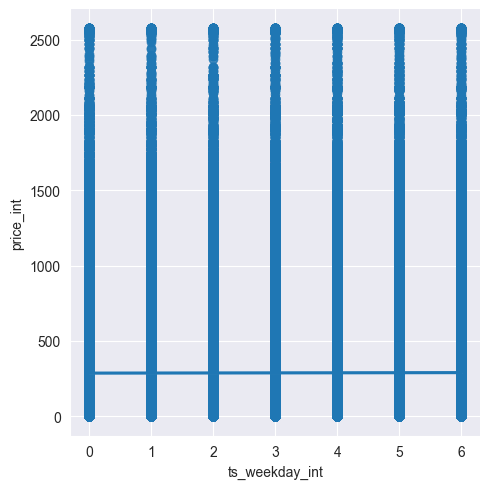

In [15]:
sns.lmplot(x='ts_weekday_int', y='price_int', data=pandas_df_s)

In [6]:
#value filtering data using 3 std distance
std_val = df_casted.agg({'price_int': 'stddev'}).collect()[0][0]
mean_val = df_casted.agg({'price_int': 'mean'}).collect()[0][0]

hi_bound = mean_val+(3*std_val)
low_bound = mean_val-(3*std_val)

df_filtered = df_casted.where((df_casted['price_int'] < hi_bound) & (df_casted['price_int'] > low_bound))
num_rows = df_filtered.count()
print(df_casted.count())
print(num_rows)
#df_filtered.show()

11495242
11203806


In [19]:
df_casted.dropna(how='any', thresh=50, subset=['ts_weekday_int']) #if in how 'any' than drop a record if it contains any nulls.
# If 'all' drop a record only if all its values are null
#thresh: int, if specified drop records that have less than tresh non-null values, overwrites the how parameter
#subset: optional list of column names to consider

DataFrame[event_time: string, event_type: string, product_id: string, brand: string, user_id: string, user_session: string, target: bigint, cat_0: string, cat_1: string, cat_2: string, cat_3: string, timestamp: timestamp, ts_hour: smallint, ts_minute: smallint, price_int: double, ts_month_int: int, ts_year_int: int, ts_day_int: int, ts_weekday_int: int]

In [7]:
# MinMax scaling
# we take variable to be scaled, substract by minimum value and divide by substaction of max and min value
# Xi,j* = (Xi,j - Xj MIN) / (Xj MAX - Xj MIN) 

max_price = df_casted.agg({'price_int': 'max'}).collect()[0][0]
min_price = df_casted.agg({'price_int': 'min'}).collect()[0][0]

df_casted = df_casted.withColumn("scaled_price",
                                 (df_casted['price_int'] - min_price) / (max_price - min_price))
df_casted[['scaled_price']].show(5)

+-------------------+
|       scaled_price|
+-------------------+
| 0.1954453453091796|
| 0.3688594327271597|
| 0.1891168460842168|
| 0.1891168460842168|
|0.06237981096085187|
+-------------------+
only showing top 5 rows



In [8]:
# Standardization - transforming data to standard normal distribution, mean = 0 and std = 1
df_casted = df_casted.withColumn("ztrans_price",
                                 (df_casted['price_int'] - mean_val) / std_val)
df_casted.agg({'ztrans_price': 'mean'}).collect()

[Row(avg(ztrans_price)=-2.4421258171688696e-14)]

In [22]:
df_casted.agg({'ztrans_price': 'stddev'}).collect()

[Row(stddev(ztrans_price)=0.9999999999999991)]

<Axes: ylabel='Count'>

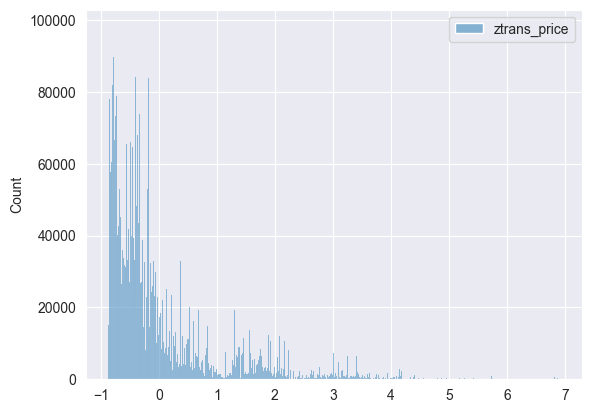

In [23]:
sam_df = df_casted.select('ztrans_price').sample(False, 0.5, 42)

pan_df = sam_df.toPandas()
sns.histplot(pan_df)

<Axes: ylabel='Count'>

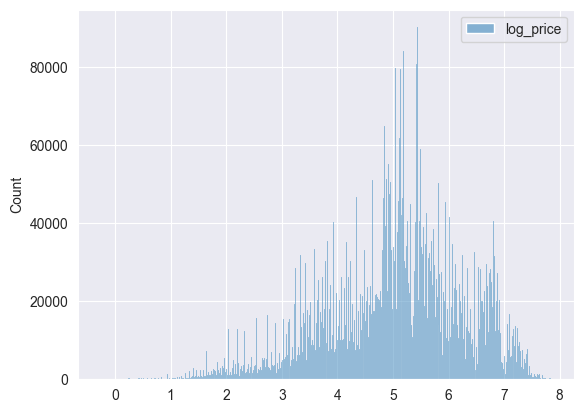

In [24]:
#log scaling
from pyspark.sql.functions import log

df_casted = df_casted.withColumn('log_price', log(df_casted['price_int']))

sa_df = df_casted.select('log_price').sample(False, 0.5, 42)

pa_df = sa_df.toPandas()
sns.histplot(pa_df)

In [25]:
# How to deal with missing values?
# Process of replacing missing values:
# rule based:
#   Value based on business logic
# Statistics based:
#       Using mean, median, etc
# Model Based:
#   Use model to predict value

df_casted.where(df_casted['price_int'].isNull()).count()

#imputation of missing valuesL
df_casted.fillna(0, subset=['price_int']) #filling missing values with 0
df_casted.fillna(mean_val, subset=['price_int']) #filling with mean value

DataFrame[event_time: string, event_type: string, product_id: string, brand: string, user_id: string, user_session: string, target: bigint, cat_0: string, cat_1: string, cat_2: string, cat_3: string, timestamp: timestamp, ts_hour: smallint, ts_minute: smallint, price_int: double, ts_month_int: int, ts_year_int: int, ts_day_int: int, ts_weekday_int: int, scaled_price: double, ztrans_price: double, log_price: double]

In [26]:
# types of JOINS:
# INNER JOIN (only values present in both datasets)
# FULL JOIN ( everything)
# LEFT JOIN ( left dataset with values which are present in both datasets)
# RIGHT JOIN ( right dataset with common values of both datasets )
# if left data set is our starting data set we want to keep it so always use left join!

# spark method join:
DataFrame.join(
    other,  # other dataFrame to merge 
    on=None,    # the kys to join on
    how=None    # type of join to perform (default is 'inner')
)

#SQL join type:

#create temp table:
df_casted.createOrReplaceTempView('df_casted')
otherDataFrame.createOrReplaceTempView('otherDataFrame')

sql_df = spark.sql("""
                    SELECT * FROM df_casted
                    LEFT JOIN otherDataFrame
                    ON df_casted.id = otherDataFrame.id
                    """)

NameError: name 'DataFrame' is not defined

C:\Users\kizer\miniconda3\envs\spark354_env\lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\kizer\miniconda3\envs\spark354_env\lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\kizer\miniconda3\envs\spark354_env\lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\kizer\miniconda3\envs\spark354_env\lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not

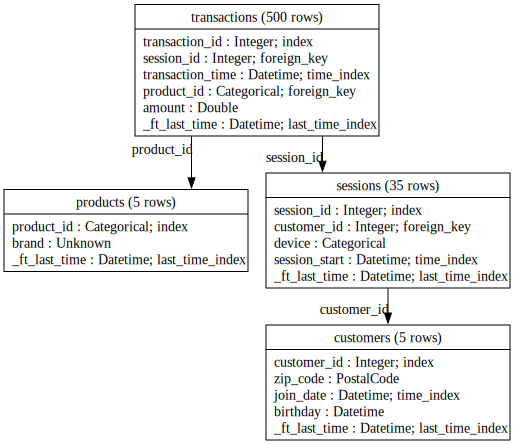

In [8]:
#feature generation
# as we divide, sum, subtract or multiply some variables in our dataframe we could obtain some new, good features
# libraries for automation of features: featureTools & TSFresh
import featuretools as ft

es = ft.demo.load_mock_customer(return_entityset=True)
es.plot()

In [9]:
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, \
    load_robot_execution_failures
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()
print(timeseries.head())

   id  time  F_x  F_y  F_z  T_x  T_y  T_z
0   1     0   -1   -1   63   -3   -1    0
1   1     1    0    0   62   -3   -1    0
2   1     2   -1   -1   61   -3    0    0
3   1     3   -1   -1   63   -2   -1    0
4   1     4   -1   -1   63   -3   -1    0


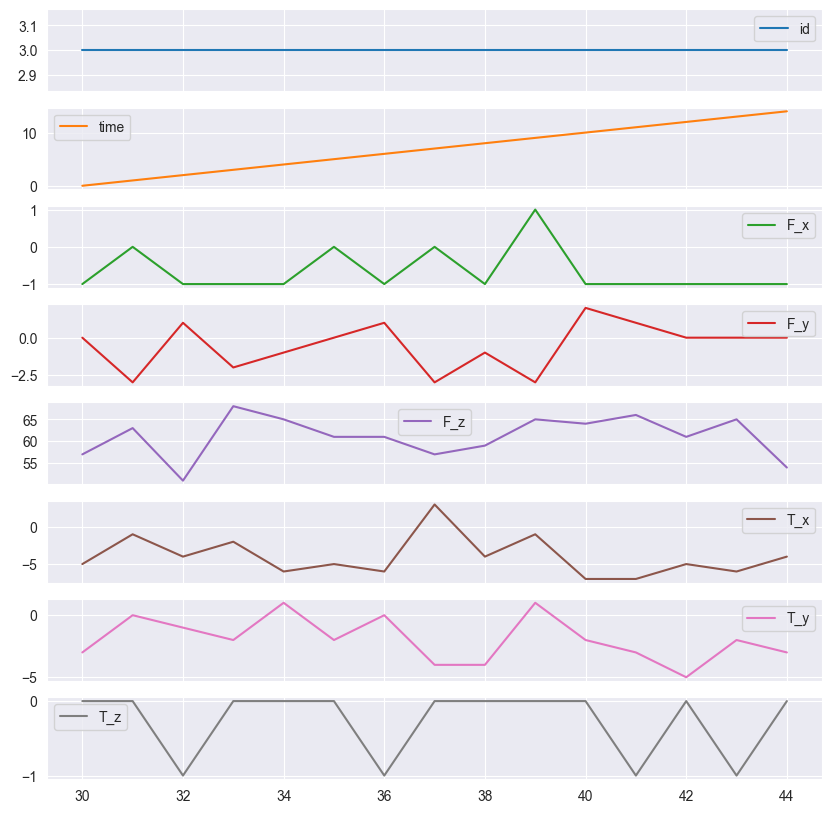

In [10]:
import matplotlib.pyplot as plt
timeseries[timeseries['id'] == 3].plot(subplots=True, sharex=True, figsize=(10,10))
plt.show()

In [14]:
#time features
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import col
df_casted = df_casted.withColumn("c", to_timestamp(col("event_time"), "yyyy-MM-dd HH:mm:ss z"))
df_casted[['c']].show()
df_casted.printSchema()
#df_casted.describe()

+-------------------+
|                  c|
+-------------------+
|2019-11-01 01:00:14|
|2019-11-01 01:03:39|
|2019-11-01 01:05:54|
|2019-11-01 01:07:22|
|2019-11-01 01:10:45|
|2019-11-01 01:13:40|
|2019-11-01 01:14:09|
|2019-11-01 01:14:23|
|2019-11-01 01:15:23|
|2019-11-01 01:15:46|
|2019-11-01 01:15:56|
|2019-11-01 01:20:25|
|2019-11-01 01:20:49|
|2019-11-01 01:24:48|
|2019-11-01 01:25:12|
|2019-11-01 01:30:05|
|2019-11-01 01:30:35|
|2019-11-01 01:31:35|
|2019-11-01 01:33:37|
|2019-11-01 01:35:55|
+-------------------+
only showing top 20 rows

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)
 |-- target: long (nullable = true)
 |-- cat_0: string (nullable = true)
 |-- cat_1: string (nullable = true)
 |-- cat_2: string (nullable = true)
 |-- cat_3: string (nullable = true)
 |-- timest

In [32]:
from pyspark.sql.functions import regexp_extract

df_casted = df_casted.withColumn("timezone", regexp_extract(col('event_time'), r'(\w+)$', 1))
df_casted[['timezone']].show()

+--------+
|timezone|
+--------+
|     UTC|
|     UTC|
|     UTC|
|     UTC|
|     UTC|
|     UTC|
|     UTC|
|     UTC|
|     UTC|
|     UTC|
|     UTC|
|     UTC|
|     UTC|
|     UTC|
|     UTC|
|     UTC|
|     UTC|
|     UTC|
|     UTC|
|     UTC|
+--------+
only showing top 20 rows



In [34]:
from pyspark.sql.functions import year, month, dayofmonth, weekofyear, hour, dayofweek

df_casted = df_casted.withColumn('extracted_year', year('c'))
df_casted = df_casted.withColumn('extracted_month', month('c'))
df_casted = df_casted.withColumn('extracted_day_month', dayofmonth('c'))
df_casted = df_casted.withColumn('extracted_week_year', weekofyear('c'))
df_casted.show()

+--------------------+----------+----------+-------+---------+--------------------+------+-----------+----------+---------+-----+-------------------+-------+---------+---------+------------+-----------+----------+--------------+--------------------+--------------------+-------------------+-------------------+--------------+---------------+-------------------+-------------------+--------+
|          event_time|event_type|product_id|  brand|  user_id|        user_session|target|      cat_0|     cat_1|    cat_2|cat_3|          timestamp|ts_hour|ts_minute|price_int|ts_month_int|ts_year_int|ts_day_int|ts_weekday_int|        scaled_price|        ztrans_price|    event_time_corr|                  c|extracted_year|extracted_month|extracted_day_month|extracted_week_year|timezone|
+--------------------+----------+----------+-------+---------+--------------------+------+-----------+----------+---------+-----+-------------------+-------+---------+---------+------------+-----------+----------+-----

In [36]:
from pyspark.sql.functions import datediff #function to calculate difference between two date fields

# Lagging features 
# window() return a record based off a group of records
# lag(col, count=1)
# returns the value that is offset by rows before the current row

from pyspark.sql.functions import lag
from pyspark.sql.window import Window

w = Window().orderBy(df_casted['c'])

df_casted = df_casted.withColumn('price-1wk', lag('price_int', 1).over(w))
df_casted.show()

+--------------------+----------+----------+-------+---------+--------------------+------+-----------+-----------+---------+-----+-------------------+-------+---------+---------+------------+-----------+----------+--------------+--------------------+--------------------+-------------------+-------------------+--------------+---------------+-------------------+-------------------+--------+---------+
|          event_time|event_type|product_id|  brand|  user_id|        user_session|target|      cat_0|      cat_1|    cat_2|cat_3|          timestamp|ts_hour|ts_minute|price_int|ts_month_int|ts_year_int|ts_day_int|ts_weekday_int|        scaled_price|        ztrans_price|    event_time_corr|                  c|extracted_year|extracted_month|extracted_day_month|extracted_week_year|timezone|price-1wk|
+--------------------+----------+----------+-------+---------+--------------------+------+-----------+-----------+---------+-----+-------------------+-------+---------+---------+------------+-----

In [ ]:
from pyspark.sql.functions import when
find_in_text = df_casted['user_session'].like('%text_to_find%') # looking for specific text in whole text in column where this text is stored
df_casted = df.withColumn('new_column', (when(find_in_text, 1)).otherwise(0))

In [6]:
from pyspark.sql.functions import split

split_col = split(df_casted['event_time'], ' ')
df_casted = df_casted.withColumn('date', split_col.getItem(0))
df_casted[['event_time', 'date']].show()

+--------------------+----------+
|          event_time|      date|
+--------------------+----------+
|2019-11-01 00:00:...|2019-11-01|
|2019-11-01 00:03:...|2019-11-01|
|2019-11-01 00:05:...|2019-11-01|
|2019-11-01 00:07:...|2019-11-01|
|2019-11-01 00:10:...|2019-11-01|
|2019-11-01 00:13:...|2019-11-01|
|2019-11-01 00:14:...|2019-11-01|
|2019-11-01 00:14:...|2019-11-01|
|2019-11-01 00:15:...|2019-11-01|
|2019-11-01 00:15:...|2019-11-01|
|2019-11-01 00:15:...|2019-11-01|
|2019-11-01 00:20:...|2019-11-01|
|2019-11-01 00:20:...|2019-11-01|
|2019-11-01 00:24:...|2019-11-01|
|2019-11-01 00:25:...|2019-11-01|
|2019-11-01 00:30:...|2019-11-01|
|2019-11-01 00:30:...|2019-11-01|
|2019-11-01 00:31:...|2019-11-01|
|2019-11-01 00:33:...|2019-11-01|
|2019-11-01 00:35:...|2019-11-01|
+--------------------+----------+
only showing top 20 rows



In [21]:
df_casted.describe()

DataFrame[summary: string, event_time: string, event_type: string, product_id: string, brand: string, user_id: string, user_session: string, target: string, cat_0: string, cat_1: string, cat_2: string, cat_3: string, ts_hour: string, ts_minute: string, price_int: string, ts_month_int: string, ts_year_int: string, ts_day_int: string, ts_weekday_int: string, date: string]

In [18]:
from pyspark.sql.functions import to_date
df_casted = df_casted.withColumn('prop_date', to_date(df_casted['date'], 'yyyy-MM-dd'))
df_casted[['prop_date']].show()

+----------+
| prop_date|
+----------+
|2019-11-01|
|2019-11-01|
|2019-11-01|
|2019-11-01|
|2019-11-01|
|2019-11-01|
|2019-11-01|
|2019-11-01|
|2019-11-01|
|2019-11-01|
|2019-11-01|
|2019-11-01|
|2019-11-01|
|2019-11-01|
|2019-11-01|
|2019-11-01|
|2019-11-01|
|2019-11-01|
|2019-11-01|
|2019-11-01|
+----------+
only showing top 20 rows



In [10]:
sample_df = df_casted.sample(False, 0.0008, 42)
sample_df.count()

9322

In [21]:
from pyspark.sql.functions import split, explode, lit,coalesce, first

sample_df = sample_df.withColumn('date_list', split(sample_df['event_time'], ' '))
ex_df = sample_df.withColumn('ex_date_list', explode(sample_df['date_list']))
ex_df = ex_df.withColumn('constant_value', lit(1))
#piv_df = ex_df.groupBy('cat_1').pivot('ex_date_list').agg(coalesce(first('constant_value')))

In [ ]:
#binarizing

from pyspark.ml.feature import Binarizer

# using Binarizer we set anythin over 0 to be converted to 1 and 0 to 0. we need double  type of data

bin = Binarizer(threshold=0.0, inputCol='target', outputCol='target_t') # doesn't make sens in my case
df_casted = bin.transform(df_casted)

In [36]:
#Bucketing
from pyspark.ml.feature import Bucketizer

splits = [0,1,2, float('Inf')]

buck = Bucketizer(splits=splits, inputCol='price_int', outputCol='price_bucket')
df = buck.transform(df_casted)

df[['price_int', 'price_bucket']].show()

+---------+------------+
|price_int|price_bucket|
+---------+------------+
|   503.09|         2.0|
|   949.47|         2.0|
|    486.8|         2.0|
|    486.8|         2.0|
|   160.57|         2.0|
|   362.29|         2.0|
|   128.42|         2.0|
|   128.42|         2.0|
|   949.47|         2.0|
|  1013.86|         2.0|
|  1013.86|         2.0|
|   275.25|         2.0|
|   275.25|         2.0|
|     22.8|         2.0|
|     22.8|         2.0|
|   358.31|         2.0|
|   128.42|         2.0|
|    488.8|         2.0|
|   469.84|         2.0|
|   242.63|         2.0|
+---------+------------+
only showing top 20 rows



In [46]:
df_casted[['brand']].distinct().count()

sample_df = df_casted.sample(False, 0.000008, 42)
sample_df[['brand']].distinct().count()

40

In [51]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer


stringIndexer = StringIndexer(inputCol='brand', outputCol='brand_index')

model = stringIndexer.fit(sample_df)

indexed = model.transform(sample_df)

encoder = OneHotEncoder(inputCol='brand_index', outputCol='brand_vec')
encoder_model = encoder.fit(indexed)
encoded_df = encoder_model.transform(indexed)
encoded_df[['brand', 'brand_index', 'brand_vec']].show()

+--------+-----------+---------------+
|   brand|brand_index|      brand_vec|
+--------+-----------+---------------+
| samsung|        0.0| (39,[0],[1.0])|
|cordiant|       14.0|(39,[14],[1.0])|
|  xiaomi|        3.0| (39,[3],[1.0])|
| samsung|        0.0| (39,[0],[1.0])|
|  xiaomi|        3.0| (39,[3],[1.0])|
| respect|       33.0|(39,[33],[1.0])|
| samsung|        0.0| (39,[0],[1.0])|
|   apple|        1.0| (39,[1],[1.0])|
| samsung|        0.0| (39,[0],[1.0])|
|hausmann|       21.0|(39,[21],[1.0])|
|   apple|        1.0| (39,[1],[1.0])|
|  maxxis|       27.0|(39,[27],[1.0])|
| samsung|        0.0| (39,[0],[1.0])|
|   apple|        1.0| (39,[1],[1.0])|
| samsung|        0.0| (39,[0],[1.0])|
|      NA|        2.0| (39,[2],[1.0])|
|      lg|        6.0| (39,[6],[1.0])|
|  xiaomi|        3.0| (39,[3],[1.0])|
|   apple|        1.0| (39,[1],[1.0])|
|    sony|       35.0|(39,[35],[1.0])|
+--------+-----------+---------------+
only showing top 20 rows



In [52]:
#Could be done by pipeline, chaining estimator(stringIndexer and oneHotEncoder) together

from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[stringIndexer, encoder])
pipeline_model = pipeline.fit(sample_df)
encoded_df = pipeline_model.transform(sample_df)
encoded_df[['brand', 'brand_index', 'brand_vec']].show()

+--------+-----------+---------------+
|   brand|brand_index|      brand_vec|
+--------+-----------+---------------+
| samsung|        0.0| (39,[0],[1.0])|
|cordiant|       14.0|(39,[14],[1.0])|
|  xiaomi|        3.0| (39,[3],[1.0])|
| samsung|        0.0| (39,[0],[1.0])|
|  xiaomi|        3.0| (39,[3],[1.0])|
| respect|       33.0|(39,[33],[1.0])|
| samsung|        0.0| (39,[0],[1.0])|
|   apple|        1.0| (39,[1],[1.0])|
| samsung|        0.0| (39,[0],[1.0])|
|hausmann|       21.0|(39,[21],[1.0])|
|   apple|        1.0| (39,[1],[1.0])|
|  maxxis|       27.0|(39,[27],[1.0])|
| samsung|        0.0| (39,[0],[1.0])|
|   apple|        1.0| (39,[1],[1.0])|
| samsung|        0.0| (39,[0],[1.0])|
|      NA|        2.0| (39,[2],[1.0])|
|      lg|        6.0| (39,[6],[1.0])|
|  xiaomi|        3.0| (39,[3],[1.0])|
|   apple|        1.0| (39,[1],[1.0])|
|    sony|       35.0|(39,[35],[1.0])|
+--------+-----------+---------------+
only showing top 20 rows



In [48]:
#                                                           PySpark ML
#                                                               |                               
#                           ------------------------------------|----------------------------------------
#                           |                                   |                                       |
#                    Predict Category                   Predict Quantity                        Predict Similarity
#                           |                                   |                                       |
#               ------------|-----------                        |                          -------------|---------------
#               |                      |                        |                           |                           | 
#           Unlabeled Data         Labeled Data                 |                       Basket Based                User Based
#               |                       |                       |                           |                           |
#          Clustering               Classification          Regression                  Association Rules           Collaborative Filtering
#               |                       |                       |                           |                           |   
#            ml.clustering          ml.classification       ml.regression               ml.fpm                          ml.recommendation
#                                                               |
#                                                         methods:
#                                                   GeneralizedLinearRegression, IsotonicRegression, LinearRegression
#                                                   DecisionTreeeRegression, GBTRegression, RandomForestRegression
# Test and train Splits for time Series
# 1st split and training sahould be done in earliest time period and we should move in time while testing
from pyspark.sql.functions import min, max, datediff
max_date = df_casted.agg({'prop_date': 'max'}).collect()[0][0]
min_date = df_casted.agg({'prop_date': 'min'}).collect()[0][0]
print("max: ", max_date, "min: ", min_date)
date_range_df = df_casted.agg(
    datediff(max('prop_date'), min('prop_date')).alias("range_in_days")
)

date_range_df.show()

max:  2020-02-29 min:  2019-10-01
+-------------+
|range_in_days|
+-------------+
|          151|
+-------------+



In [45]:
range_in_days = date_range_df.collect()[0]['range_in_days']
print(range_in_days)

151


In [42]:
# find date to split on
from pyspark.sql.functions import date_add
import datetime
split_in_days = round(range_in_days * 0.8) # 80%, 20% split
print(type(split_in_days))


<class 'int'>


In [49]:
split_date = min_date+ datetime.timedelta(days=split_in_days)
#splitting data:
train_df = df_casted.where(df_casted['date'] < split_date)
test_df = df_casted.where(df_casted['date'] >= split_date)

In [51]:
max_date_check = train_df.agg({'date': 'max'}).collect()[0][0]
min_date_check = test_df.agg({'date': 'min'}).collect()[0][0]
print("max: ", max_date_check, "min: ", min_date_check)

max:  2020-01-29 min:  2020-01-30
